In [70]:
from pathlib import Path
from scipy.io import loadmat
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import cycle

# Rename files that don't match new naming scheme


# Actual analysis


## Data loading


In [37]:
def extract_exp_name(filename, str_pre, str_post, sep="_"):
    start_idx = filename.find(str_pre) + len(str_pre)
    end_idx = filename.find(str_post)
    return filename[start_idx:end_idx].strip(sep)
    

#### Find files

In [142]:
# Find all matching files
str_pre = "25-05-09-1508_Rothamsted_porg00475"
str_post = "npk_res_ini"
search_pattern = f"*{str_pre}*{str_post}*"
matches = Path("results/full_spinup").glob(search_pattern)
sorted_fn = sorted([str(m) for m in matches])

experiment_filepaths = {}
for fn in sorted_fn:
    exp_name = extract_exp_name(fn, str_pre, str_post)
    if exp_name != "13_N2PK":
        experiment_filepaths[exp_name] = fn

#### Load data


In [171]:
relevant_fields = {"RB_L", "NPP_L", "P", "Date", "Datam", "Zbio", "rsd", "Bio_Zs"}
data = {}
for exp, fn in experiment_filepaths.items():
    data[exp] = {
        k.rstrip("_L"): np.asarray(v)
        for k, v in loadmat(fn).items() if k in relevant_fields        
    }
    data[exp]["path"] = fn

In [172]:
for k, e in data.items():
    print(k, e["path"])

10_N2 results\full_spinup\25-05-09-1508_Rothamsted_porg00475_10_N2_npk_res_ini_0_0_0_fert_like_field_rep14.mat
16_N6PKMg results\full_spinup\25-05-09-1508_Rothamsted_porg00475_16_N6PKMg_npk_res_ini_0_0_0_fert_like_field_rep12.mat
21_FymN2 results\full_spinup\25-05-09-1508_Rothamsted_porg00475_21_FymN2_npk_res_ini_0_0_0_fert_like_field_rep03.mat
22_Fym results\full_spinup\25-05-09-1508_Rothamsted_porg00475_22_Fym_npk_res_ini_0_0_0_fert_like_field_rep13.mat
3_nil results\full_spinup\25-05-09-1508_Rothamsted_porg00475_3_nil_npk_res_ini_0_0_0_fert_like_field_rep13.mat
5_PKMg results\full_spinup\25-05-09-1508_Rothamsted_porg00475_5_PKMg_npk_res_ini_0_0_0_fert_like_field_rep12.mat
6_N1PKMg results\full_spinup\25-05-09-1508_Rothamsted_porg00475_6_N1PKMg_npk_res_ini_0_0_0_fert_like_field_rep12.mat
7_N2PKMg results\full_spinup\25-05-09-1508_Rothamsted_porg00475_7_N2PKMg_npk_res_ini_0_0_0_fert_like_field_rep14.mat
8_N3PKMg results\full_spinup\25-05-09-1508_Rothamsted_porg00475_8_N3PKMg_npk_res_i

In [173]:
for exp in data.values():
    # Year for each day of the simulation (Datam is in h, hence only every 24th)
    exp["years_daily"] = exp["Datam"][::24,0]
    exp["years"] = np.unique(exp["years_daily"])[1:]  # Skip first year as no harvest yet
    exp["years_dt"] = np.arange(str(exp["years"][0]), str(exp["years"][-1]+1), dtype="datetime64[Y]")
    exp["days_dt"] = np.arange(str(exp["years"][0]) + "-01-01", str(exp["years"][-1]+1) + "-01-01", dtype="datetime64[D]")

In [146]:
some_path = next(iter(experiment_filepaths.values()))
new_data = loadmat(some_path)
temp = np.asarray(new_data["Ta"])
prec = np.asarray(new_data["Pr"])

In [147]:
datam = np.asarray(new_data["Datam"])
temps = []
precs = []
for yr in np.unique(datam[:,0]):
    temps.append(np.mean(temp[:, datam[:,0]==yr]))
    precs.append(np.sum(prec[:, datam[:,0]==yr]))
temp_yearly = np.array(temps)
prec_yearly = np.array(precs)

## Yield

In [174]:
def get_predicted_yields(data, only_pos_values=True):
    for exp_data in data.values():
        yield_yearly_pred = np.zeros((len(exp_data["years"]), exp_data["RB"].shape[1], 7))
        for i, yr in enumerate(exp_data["years"]):
            RB_curr_yr = exp_data["RB"][1:][exp_data["years_daily"]==yr]
            if only_pos_values:
                # Set negative yields (mostly at planting) to 0
                RB_curr_yr[RB_curr_yr < 0] = 0
            yield_yearly_pred[i] = RB_curr_yr.sum(0)
        # Grains are fruit (4) and C reserve (3) compartments
        exp_data["grain_yield"] = yield_yearly_pred[:, :, [3, 4]].sum(2).squeeze(-1)
        # Straw is leaves (0), sapwood (1), and dead leaves (6) compartments
        exp_data["straw_yield"] = yield_yearly_pred[:, :, [0, 1, 6]].sum(2).squeeze(-1)

In [175]:
get_predicted_yields(data)

In [176]:
# Get observed yields
obs_path = "data/Rothamsted_yield_data.csv"
relevant_section = 1

obs_data = pd.read_csv(obs_path)
obs_data = obs_data[obs_data.section == relevant_section]

# From t/ha to gC/m2
obs_dry_matter_content = 0.8
obs_c_content = 0.45
yield_conversion_factor = obs_dry_matter_content * obs_c_content * 1e2

for exp_name, exp_data in data.items():
    strip = int(exp_name.split("_")[0])
    relevant_data = obs_data[
        (obs_data.strip == strip)
        & np.isin(obs_data.harvest_year, exp_data["years"])
    ]
    assert (exp_data["years"] == relevant_data.harvest_year.values).all()
    relevant_data.loc[relevant_data.grain=="*", "grain"] = float("nan")
    relevant_data.loc[relevant_data.straw=="*", "straw"] = float("nan")
    exp_data["grain_yield_obs"] = (relevant_data.grain.astype(float).values * yield_conversion_factor)
    exp_data["straw_yield_obs"] = (relevant_data.straw.astype(float).values * yield_conversion_factor)
    exp_data["grain_yield_obs_t/ha"] = (relevant_data.grain.astype(float).values)
    exp_data["straw_yield_obs_t/ha"] = (relevant_data.straw.astype(float).values)

In [108]:
for k, e in data.items():
    print(f"{k} - Grain: {np.nanmean(e['grain_yield_obs_t/ha']):.2f} - Straw: {np.nanmean(e['straw_yield_obs_t/ha']):.2f}")

10_N2 - Grain: 2.87 - Straw: 1.88
16_N6PKMg - Grain: 6.65 - Straw: 4.01
21_FymN2 - Grain: 7.86 - Straw: 5.93
22_Fym - Grain: 6.10 - Straw: 4.04
3_nil - Grain: 1.31 - Straw: 0.72
5_PKMg - Grain: 1.34 - Straw: 0.76
6_N1PKMg - Grain: 3.35 - Straw: 2.04
7_N2PKMg - Grain: 5.40 - Straw: 3.02
8_N3PKMg - Grain: 6.16 - Straw: 3.47
9_N4PKMg - Grain: 6.55 - Straw: 3.83


Unshifted correlation coefficient: 0.1613
Correlation coefficient when moving predictions ahead in time by...
... 1 timestep: 0.2877
... 2 timesteps: 0.0700
... 3 timesteps: -0.2254
... 4 timesteps: 0.1086
Correlation coefficient when moving predictions back in time by...
... 1 timestep: -0.0914
... 2 timesteps: -0.1948
... 3 timesteps: -0.2417
... 4 timesteps: 0.0991


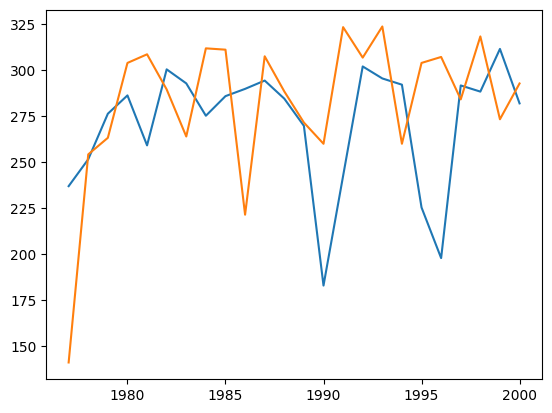

In [9]:
exp = "21_FymN2"
plt.plot(data[exp]["years"], data[exp]["grain_yield"])
plt.plot(data[exp]["years"], data[exp]["grain_yield_obs"])

corr_0 = np.corrcoef(data[exp]["grain_yield"], data[exp]["grain_yield_obs"])[0,1]
print(f"Unshifted correlation coefficient: {corr_0:.4f}")

print("Correlation coefficient when moving predictions ahead in time by...")
for shift in range(1, 5):
    pred = data[exp]["grain_yield"][shift:]
    obs = data[exp]["grain_yield_obs"][:-shift]
    corr = np.corrcoef(pred, obs)[0,1]
    print(f"... {shift} timestep{'' if shift==1 else 's'}: {corr:.4f}")
print("Correlation coefficient when moving predictions back in time by...")
for shift in range(1, 5):
    pred = data[exp]["grain_yield"][:-shift]
    obs = data[exp]["grain_yield_obs"][shift:]
    corr = np.corrcoef(pred, obs)[0,1]
    print(f"... {shift} timestep{'' if shift==1 else 's'}: {corr:.4f}")

In [10]:
plt.plot(normalize(data[exp]["grain_yield"][1:]))
plt.plot(normalize(data[exp]["grain_yield_obs"][:-1]))

NameError: name 'normalize' is not defined

In [177]:
for exp in data.values():
    for yield_type in ("grain", "straw"):
        varname_mod = f"{yield_type}_yield"
        varname_obs = f"{yield_type}_yield_obs"
        obs_available = ~np.isnan(exp[varname_obs])
        for varname in [varname_mod, varname_obs]:
            val = exp[varname][obs_available]
            mean = np.mean(val)
            std = np.std(val)            
            exp[f"mean_{varname}"] = mean
            exp[f"std_{varname}"] = std
            exp[f"normalized_{varname}"] = (val - mean) / std
            val_full = exp[varname]
            exp[f"normalized_{varname}_full"] = (val_full - np.nanmean(val_full)) / np.nanstd(val_full)

In [46]:
sns.set(font_scale=1.2)
sns.set_style("white")

In [178]:
residuals = np.array([exp["mean_grain_yield_obs"] - exp["mean_grain_yield"] for exp in data.values()])
rss = np.sum(residuals**2)
observations = np.array([exp["mean_grain_yield_obs"] for exp in data.values()])
ss = np.sum((observations - np.mean(observations))**2)
r_squared = 1 - rss/ss
print(f"R-Squared for grain yields: {r_squared}")

R-Squared for grain yields: 0.7269905834447286


In [13]:
sum(residuals)

np.float64(423.78599314209623)

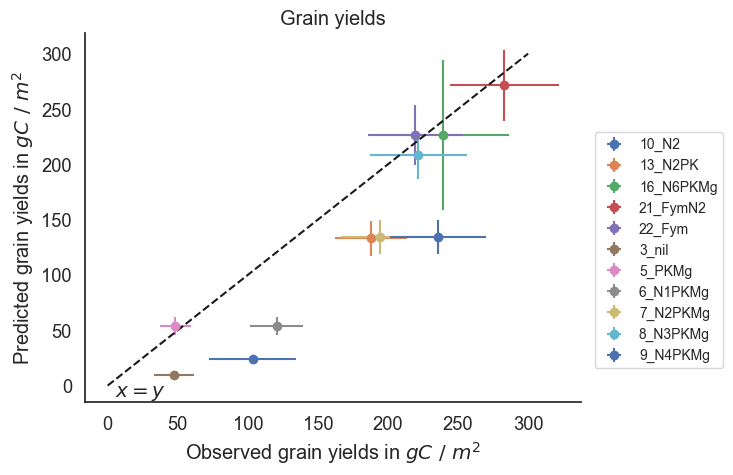

In [61]:
for k, exp in sorted(data.items()):
    x = [exp["mean_grain_yield_obs"]]
    y = [exp["mean_grain_yield"]]
    xerr = [exp["std_grain_yield_obs"]]
    yerr = [exp["std_grain_yield"]]
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, marker="o", linestyle="none", label=k)
plt.plot([0,300], [0,300], "k--")
plt.annotate("$x = y$", (5, -10))
plt.xlabel(r"Observed grain yields in $gC \ / \ m^2$")
plt.ylabel(r"Predicted grain yields in $gC \ / \ m^2$")
plt.title("Grain yields")
plt.legend(fontsize="x-small", bbox_to_anchor=(1.3, 0.75))
# plt.legend(loc="best", fontsize="x-small"
sns.despine()
plt.savefig("grain_yields.png")
plt.savefig("grain_yields.svg")

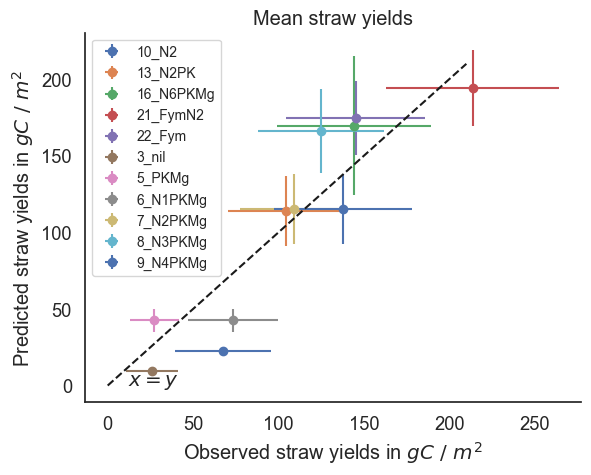

In [62]:
for k, exp in sorted(data.items()):
    x = [exp["mean_straw_yield_obs"]]
    y = [exp["mean_straw_yield"]]
    xerr = [exp["std_straw_yield_obs"]]
    yerr = [exp["std_straw_yield"]]
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, marker="o", linestyle="none", label=k)
plt.plot([0,210], [0,210], "k--")
plt.annotate("$x = y$", (12, 0))
plt.xlabel(r"Observed straw yields in $gC \ / \ m^2$")
plt.ylabel(r"Predicted straw yields in $gC \ / \ m^2$")
plt.title("Mean straw yields")
plt.legend(loc="best", fontsize="x-small")
sns.despine()
plt.savefig("straw_yields.svg")
plt.savefig("straw_yields.png")

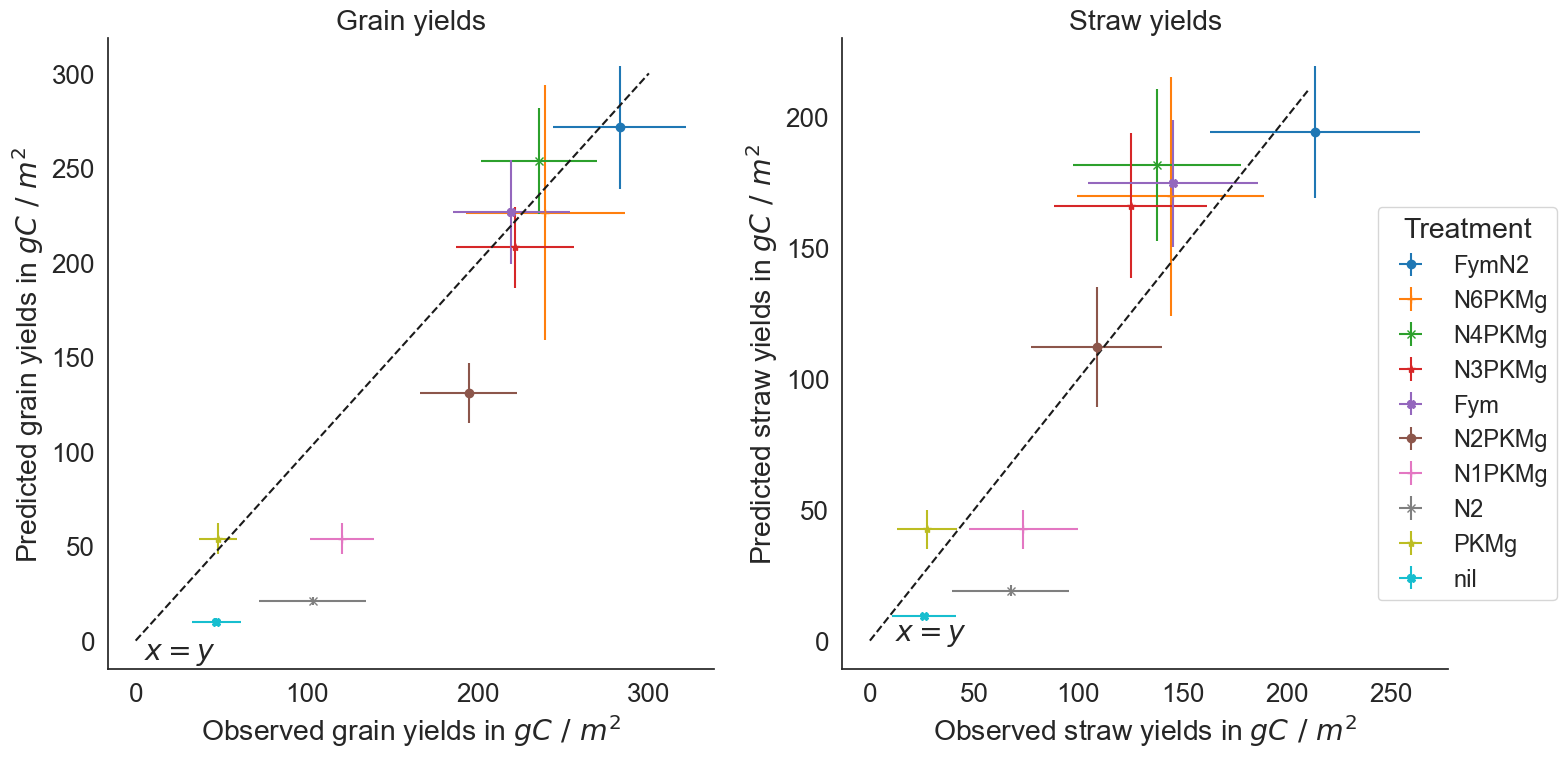

In [179]:
sns.set(font_scale=1.7)
sns.set_style("white")
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
markers = cycle(['o', '+', 'x', '*', 'X'])
# cmap = sns.color_palette('husl', len(data))
cmap = plt.get_cmap('tab10')
for i, (k, exp) in enumerate(reversed(sorted(data.items(), key=lambda x: x[1]["mean_grain_yield_obs"]))):
    label = k[k.find('_') + 1:]
    x = [exp["mean_grain_yield_obs"]]
    y = [exp["mean_grain_yield"]]
    xerr = [exp["std_grain_yield_obs"]]
    yerr = [exp["std_grain_yield"]]
    m = next(markers)
    axs[0].errorbar(x, y, xerr=xerr, yerr=yerr, marker=m, color=cmap(i), linestyle="none", label=label, markersize=6)
    x = [exp["mean_straw_yield_obs"]]
    y = [exp["mean_straw_yield"]]
    xerr = [exp["std_straw_yield_obs"]]
    yerr = [exp["std_straw_yield"]]
    axs[1].errorbar(x, y, xerr=xerr, yerr=yerr, marker=m, color=cmap(i), linestyle="none", label=label, markersize=6)
axs[0].plot([0,300], [0,300], "k--")
axs[1].plot([0,210], [0,210], "k--")
axs[0].annotate("$x = y$", (5, -10))
axs[1].annotate("$x = y$", (12, 0))
axs[0].set_xlabel(r"Observed grain yields in $gC \ / \ m^2$")
axs[1].set_xlabel(r"Observed straw yields in $gC \ / \ m^2$")
axs[0].set_ylabel(r"Predicted grain yields in $gC \ / \ m^2$")
axs[1].set_ylabel(r"Predicted straw yields in $gC \ / \ m^2$")
axs[0].set_title("Grain yields")
axs[1].set_title("Straw yields")
axs[1].legend(fontsize="small", bbox_to_anchor=(1.2, 0.75), title="Treatment")
plt.tight_layout()
# plt.legend(loc="best", fontsize="x-small"
sns.despine()
plt.savefig("both_yields.png")
#plt.savefig("grain_yields.svg")

#### Pearson correlation coefficient

In [181]:
annual_grain_yield_means = np.mean(np.vstack([exp["normalized_grain_yield"] for exp in data.values()]), 0)
annual_grain_yield_means_obs = np.mean(np.vstack([exp["normalized_grain_yield_obs"] for exp in data.values()]), 0)
annual_grain_yield_std = np.std(np.vstack([exp["normalized_grain_yield"] for exp in data.values()]), 0)
annual_grain_yield_std_obs = np.std(np.vstack([exp["normalized_grain_yield_obs"] for exp in data.values()]), 0)

In [182]:
corr = np.corrcoef(annual_grain_yield_means, annual_grain_yield_means_obs)[0,1]
print(f"Pearson correlation: {corr:.4f}")

Pearson correlation: -0.1865


##### Significance of correlation

In [184]:
count=0
N = 10000
for i in range(N):
    perm = np.random.permutation(annual_grain_yield_means_obs)
    if np.abs(np.corrcoef(annual_grain_yield_means, perm)[0,1]) > np.abs(corr):
        count += 1
print(f"p-value of the correlation coefficient (two-sided): {count / N:.3f}")

p-value of the correlation coefficient (one-sided): 0.387


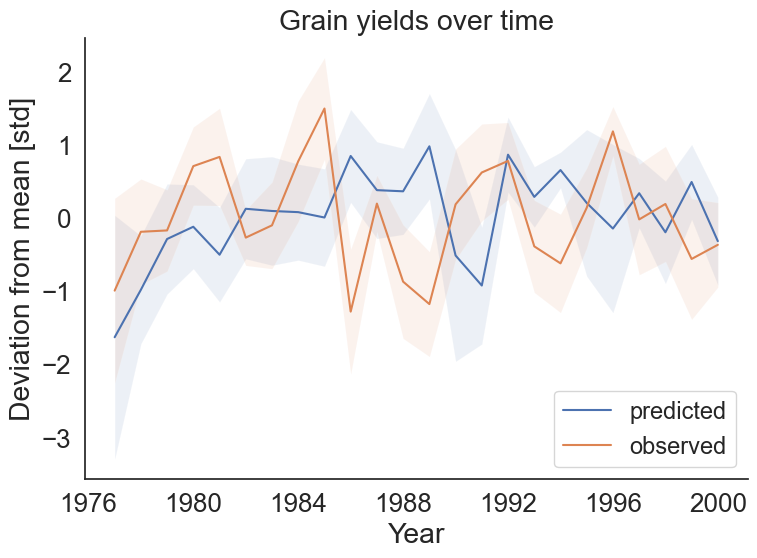

In [195]:
plt.figure(figsize=(8, 6))
plt.plot(data["22_Fym"]["years_dt"], annual_grain_yield_means, label="predicted")
plt.plot(data["22_Fym"]["years_dt"], annual_grain_yield_means_obs, label="observed")
plt.fill_between(data["22_Fym"]["years_dt"], annual_grain_yield_means-annual_grain_yield_std, annual_grain_yield_means+annual_grain_yield_std, alpha=0.1)
plt.fill_between(data["22_Fym"]["years_dt"], annual_grain_yield_means_obs-annual_grain_yield_std_obs, annual_grain_yield_means_obs+annual_grain_yield_std_obs, alpha=0.1)
# plt.plot(data["22_Fym"]["years_dt"], normalize(temp_yearly[:-1]), "k--", label="temperature")
# plt.plot(data["22_Fym"]["years_dt"], normalize(prec_yearly[:-1]), "r--", label="temperature")
plt.xlabel("Year")
plt.ylabel("Deviation from mean [std]")
plt.title("Grain yields over time")
plt.legend(loc="best", fontsize="small")
sns.despine()
plt.tight_layout()
plt.savefig("grain_yields_annual.svg")
plt.savefig("grain_yields_annual.png")

In [86]:
annual_straw_yield_means = np.mean(np.vstack([exp["normalized_straw_yield_full"] for exp in data.values()]), 0)
annual_straw_yield_means_obs = np.mean(np.vstack([exp["normalized_straw_yield_obs_full"] for exp in data.values()]), 0)
annual_straw_yield_std = np.std(np.vstack([exp["normalized_straw_yield_full"] for exp in data.values()]), 0)
annual_straw_yield_std_obs = np.std(np.vstack([exp["normalized_straw_yield_obs_full"] for exp in data.values()]), 0)

In [88]:
data["22_Fym"]["years_dt"][np.isnan(annual_straw_yield_means_obs)]

array(['1987'], dtype='datetime64[Y]')

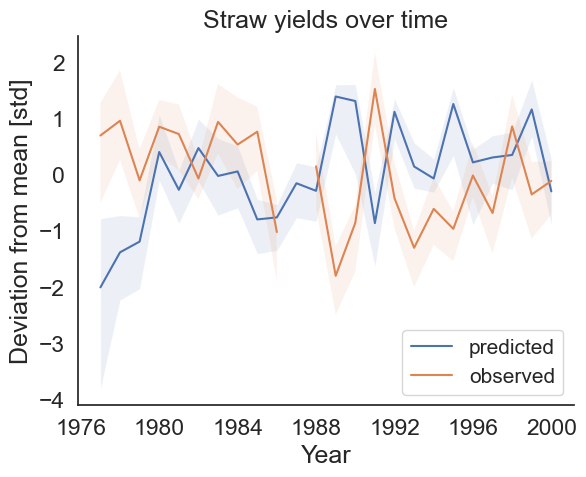

In [87]:
plt.plot(data["22_Fym"]["years_dt"], annual_straw_yield_means, label="predicted")
plt.plot(data["22_Fym"]["years_dt"], annual_straw_yield_means_obs, label="observed")
plt.fill_between(data["22_Fym"]["years_dt"], annual_straw_yield_means-annual_grain_yield_std, annual_straw_yield_means+annual_straw_yield_std, alpha=0.1)
plt.fill_between(data["22_Fym"]["years_dt"], annual_straw_yield_means_obs-annual_grain_yield_std_obs, annual_straw_yield_means_obs+annual_straw_yield_std_obs, alpha=0.1)
plt.xlabel("Year")
plt.ylabel("Deviation from mean [std]")
plt.title("Straw yields over time")
plt.legend(loc="best", fontsize="small")
sns.despine()
plt.savefig("straw_yields_annual.svg")
plt.savefig("straw_yields_annual.png")

#### Correlation with y0=1

In [17]:
annual_grain_yield_0 = np.mean(np.vstack([exp["grain_yield"] / exp["grain_yield"][0] for exp in data.values()]), 0)
annual_grain_yield_0_obs = np.mean(np.vstack([exp["grain_yield_obs"] / exp["grain_yield_obs"][0] for exp in data.values()]), 0)

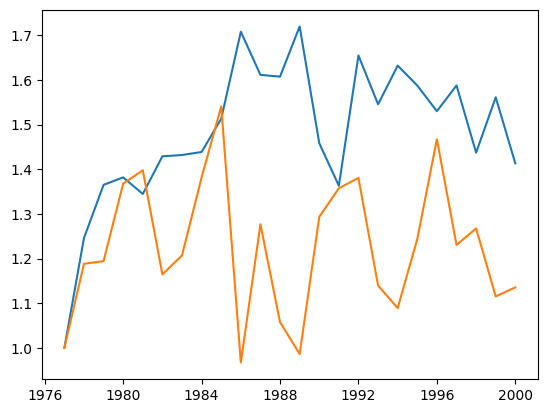

In [18]:
plt.plot(data["22_Fym"]["years_dt"], annual_grain_yield_0)
plt.plot(data["22_Fym"]["years_dt"], annual_grain_yield_0_obs)

In [19]:
corr = np.corrcoef(annual_grain_yield_0, annual_grain_yield_0_obs)[0,1]
print(f"Pearson correlation: {corr:.4f}")

Pearson correlation: -0.0818


#### Correlation, shifted and normalized by mean

In [20]:
def norm_by_mean(x):
    return (x-np.mean(x)) / np.mean(x)

In [21]:
annual_grain_yield_mm = np.mean(np.vstack([norm_by_mean(exp["grain_yield"]) for exp in data.values()]), 0)
annual_grain_yield_mm_obs = np.mean(np.vstack([norm_by_mean(exp["grain_yield_obs"]) for exp in data.values()]), 0)

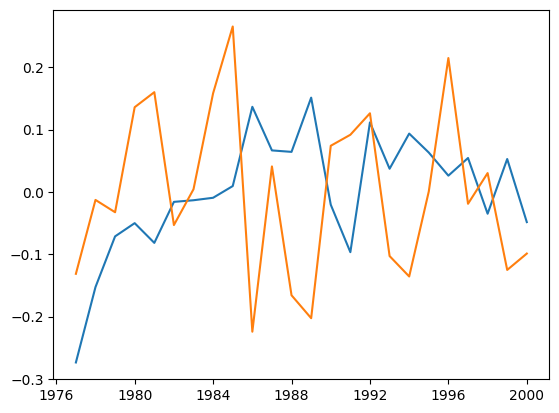

In [22]:
plt.plot(data["22_Fym"]["years_dt"], annual_grain_yield_mm)
plt.plot(data["22_Fym"]["years_dt"], annual_grain_yield_mm_obs)

In [23]:
corr = np.corrcoef(annual_grain_yield_mm, annual_grain_yield_mm_obs)[0,1]
print(f"Pearson correlation: {corr:.4f}")

Pearson correlation: -0.1976


#### Correlation, only mean-shifted

In [24]:
def shift_by_mean(x):
    return x-np.mean(x)

In [25]:
annual_grain_yield_ms = np.mean(np.vstack([shift_by_mean(exp["grain_yield"]) for exp in data.values()]), 0)
annual_grain_yield_ms_obs = np.mean(np.vstack([shift_by_mean(exp["grain_yield_obs"]) for exp in data.values()]), 0)

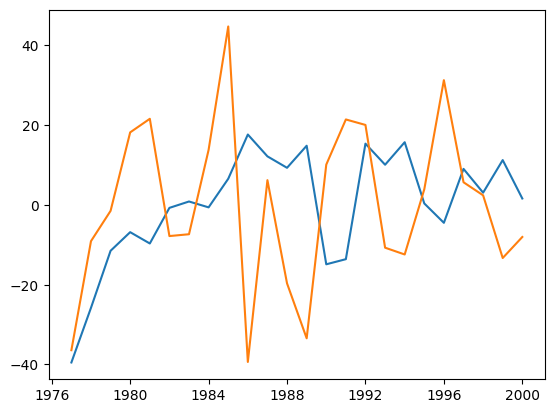

In [26]:
plt.plot(data["22_Fym"]["years_dt"], annual_grain_yield_ms)
plt.plot(data["22_Fym"]["years_dt"], annual_grain_yield_ms_obs)

In [27]:
corr = np.corrcoef(annual_grain_yield_ms, annual_grain_yield_ms_obs)[0,1]
print(f"Pearson correlation: {corr:.4f}")

Pearson correlation: -0.0497


#### Correlation across individual points

In [164]:
all_gym = np.hstack([exp["normalized_grain_yield"][1:] for exp in data.values()])
all_gym_o = np.hstack([exp["normalized_grain_yield_obs"][:-1] for exp in data.values()])
corr_all = np.corrcoef(all_gym, all_gym_o)[0,1]

In [164]:
all_gym = np.hstack([exp["normalized_grain_yield"][1:] for exp in data.values()])
all_gym_o = np.hstack([exp["normalized_grain_yield_obs"][:-1] for exp in data.values()])
corr_all = np.corrcoef(all_gym, all_gym_o)[0,1]

In [165]:
count=0
N = 10000
for i in range(N):
    perm = np.random.permutation(all_gym_o)
    if np.corrcoef(all_gym, perm)[0,1] > corr_all:
        count += 1
print(f"p-value of the correlation coefficient (one-sided): {count / N:.3f}")

p-value of the correlation coefficient (one-sided): 0.059


In [146]:
window_size = 5
ag5 = np.lib.stride_tricks.sliding_window_view(
    annual_grain_yield_means, window_shape=5).mean(1)
ag5_obs = np.lib.stride_tricks.sliding_window_view(
    annual_grain_yield_means_obs, window_shape=5).mean(1)

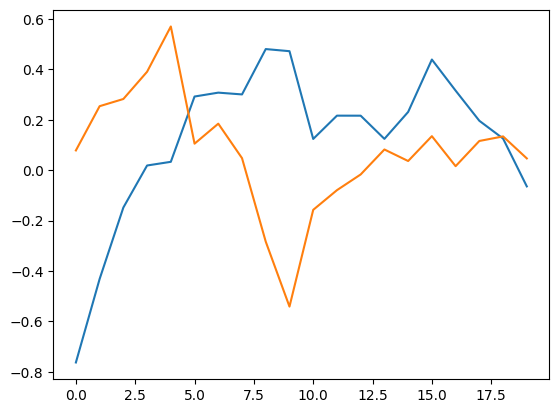

In [147]:
plt.plot(ag5)
plt.plot(ag5_obs)

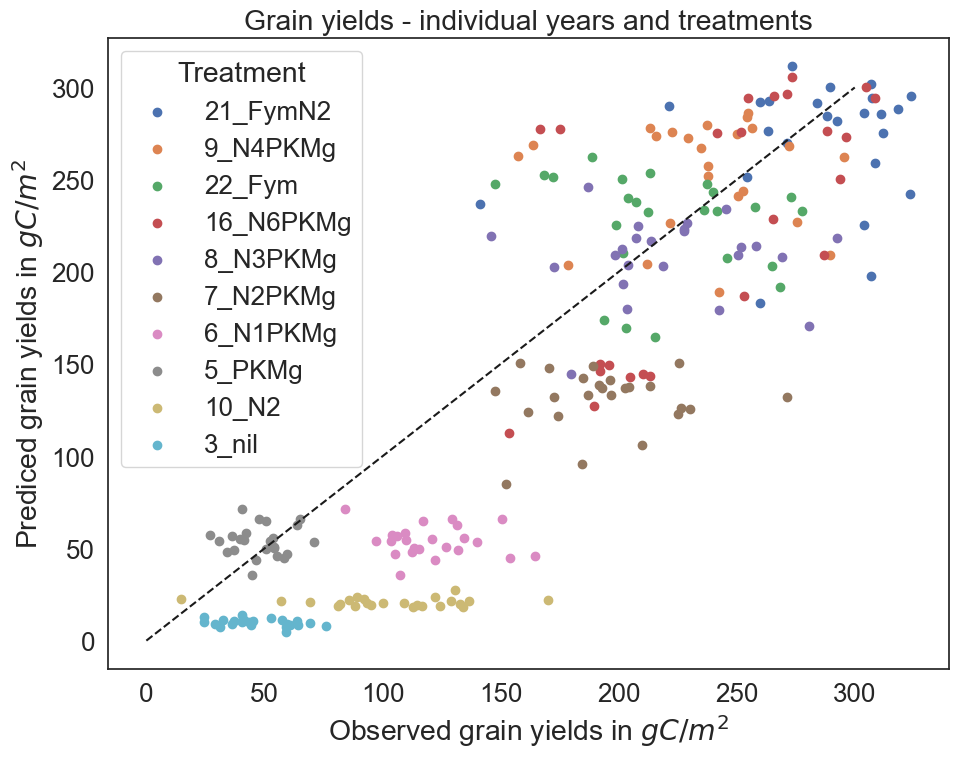

In [205]:
plt.figure(figsize=(10,8))
for i, (name, exp) in enumerate(reversed(sorted(data.items(), key=lambda x:x[1]["mean_grain_yield"]))):
    plt.scatter(exp["grain_yield_obs"], exp["grain_yield"], label=name)
plt.plot([0,300], [0,300], "k--")
plt.title("Grain yields - individual years and treatments")
plt.xlabel(r"Observed grain yields in $gC / m^2$")
plt.ylabel(r"Prediced grain yields in $gC / m^2$")
plt.legend(loc="best", title="Treatment")
plt.tight_layout()
plt.savefig("grain_yields_individual_years.png")

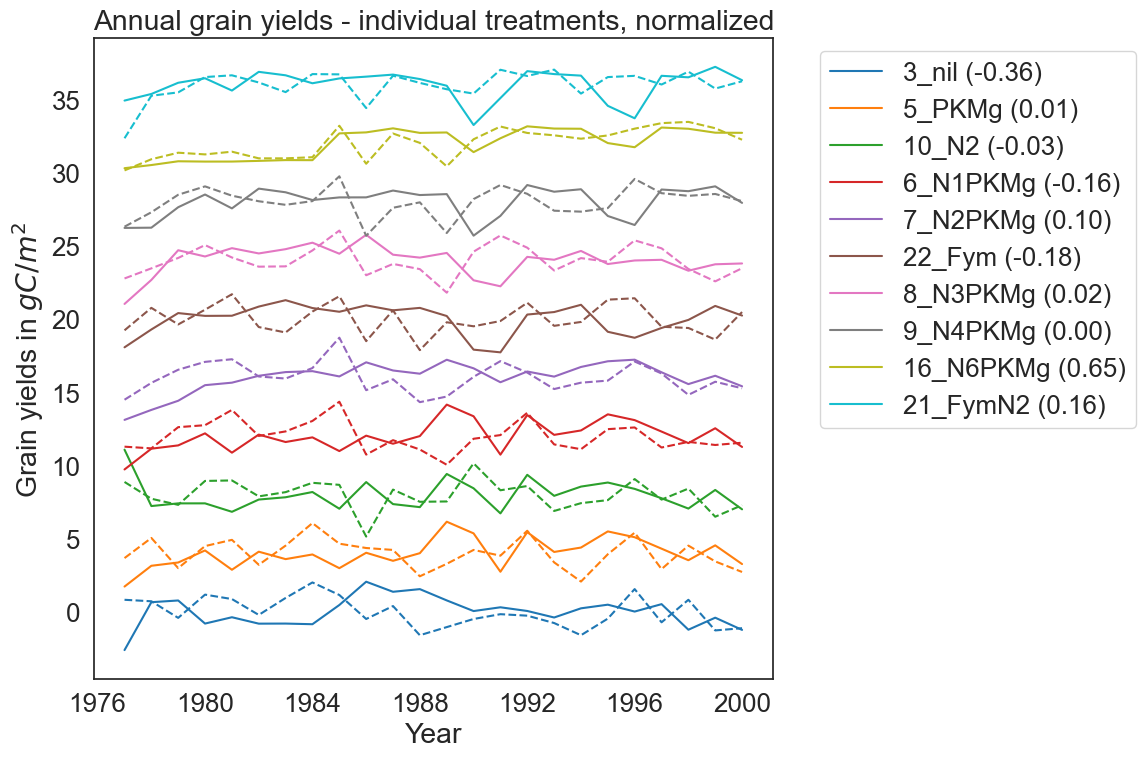

In [213]:
plt.figure(figsize=(12,8))
cmap = plt.get_cmap("tab10")
for i, (name, exp) in enumerate(sorted(data.items(), key=lambda x:x[1]["mean_grain_yield_obs"])):
    pcc = np.corrcoef(exp["grain_yield"], exp["grain_yield_obs"])[0,1]
    plt.plot(exp["years_dt"], 4*i + normalize(exp["grain_yield"]), label=f"{name} ({pcc:.2f})", color=cmap(i))
    plt.plot(exp["years_dt"], 4*i + normalize(exp["grain_yield_obs"]), linestyle="--", color=cmap(i))
plt.title("Annual grain yields - individual treatments, normalized")
plt.xlabel(r"Year")
plt.ylabel(r"Grain yields in $gC / m^2$")
plt.legend(loc="best", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig("annual_grain_yields_individual.png")

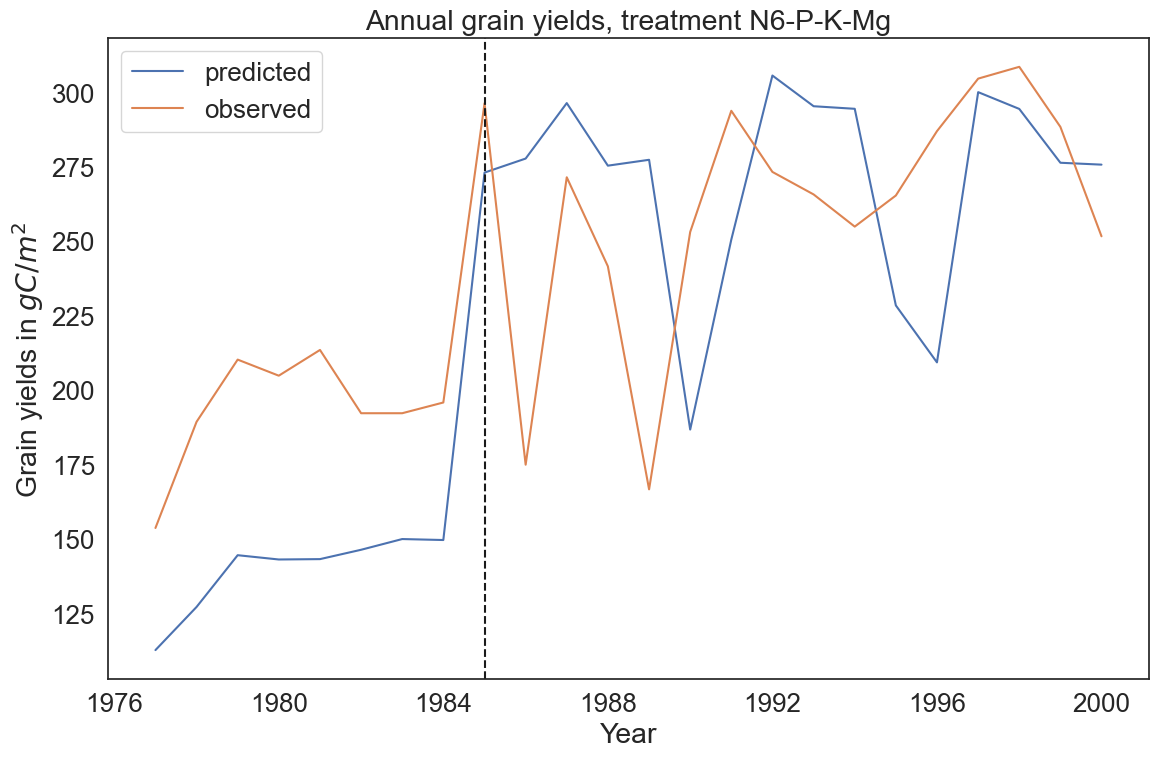

In [221]:
plt.figure(figsize=(12,8))
exp = data["16_N6PKMg"]
plt.plot(exp["years_dt"], exp["grain_yield"], label="predicted")
plt.plot(exp["years_dt"], exp["grain_yield_obs"], label="observed")
plt.title("Annual grain yields, treatment N6-P-K-Mg")
plt.xlabel(r"Year")
plt.ylabel(r"Grain yields in $gC / m^2$")
plt.axvline(np.datetime64("1985"), color="k", ls="--")
plt.legend(loc="best") #, bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig("annual_grain_yields_N6PKMg.png")

In [212]:
for name, exp in data.items():
    print(name)
    print(np.corrcoef(exp["grain_yield_obs"][:-1], exp["grain_yield"][1:])[0,1])
    print()

10_N2
-0.15738367837785786

16_N6PKMg
0.7120081992272467

21_FymN2
0.28770310756979606

22_Fym
0.01060998910588878

3_nil
0.17321075549670417

5_PKMg
-0.4624844737786963

6_N1PKMg
-0.19784346114218318

7_N2PKMg
0.1313913990481231

8_N3PKMg
0.34123633131955905

9_N4PKMg
0.5097849416592679



In [177]:
corr_coeffs = [np.corrcoef(exp["grain_yield_obs"][:], exp["grain_yield"][:])[0,1] for exp in data.values()]

In [178]:
np.mean(corr_coeffs)

np.float64(0.028950288561386886)

## Soil SOC and N

In [185]:
soc = {
    "years": np.fromiter((str(yr) for yr in [1966, 1987, 1992, 1997, 2000]), dtype="datetime64[Y]"),
    "3_nil": [0.87, 0.9, 0.77, 0.75, 0.85],
    "5_PKMg": [0.94, 0.91, 0.94, 0.82, 0.91],
    "8_N3PKMg": [1.08, 1.12, 1.07, 1.03, 1.15],
    "22_Fym": [2.61, 2.82, 2.68, 2.93, 2.89],
    "21_FymN2": [2.28, 2.34, 2.67, 2.62, 2.75],
}

soil_N = {
    "years": np.fromiter((str(yr) for yr in [1966, 1987, 1992, 1997, 2000]), dtype="datetime64[Y]"),
    "3_nil": [0.103, 0.102, 0.091, 0.09, 0.088],
    "5_PKMg": [0.109, 0.104, 0.101, 0.098, 0.094],
    "8_N3PKMg": [0.121, 0.126, 0.118, 0.119, 0.113],
    "9_N4PKMg": [0.114, 0.122, 0.122, 0.124, 0.118],
    "22_Fym": [0.255, 0.27, 0.271, 0.304, 0.273],
    "21_FymN2": [0.217, 0.228, 0.271, 0.272, 0.26],
}

In [186]:
for name, exp in data.items():
    bg_soil_mass = exp["Zbio"].squeeze() * (exp["rsd"] @ exp["Bio_Zs"].squeeze())
    soil_n_total = exp["P"][1:, 25:33].sum(1)
    soc_total = exp["P"][1:, 6:21].sum(1)
    exp["soil_N_daily"] =  soil_n_total / bg_soil_mass
    exp["SOC_daily"] = soc_total / bg_soil_mass
    exp["SOC"] = np.fromiter(
        ((exp["SOC_daily"][exp["years_daily"]==yr]).mean() for yr in exp["years"]),
        dtype=float
    )
    exp["soil_N"] = np.fromiter(
        ((exp["soil_N_daily"][exp["years_daily"]==yr]).mean() for yr in exp["years"]),
        dtype=float
    )    
    if name in soc:
        exp["SOC_obs"] = np.array(soc[name]) * 0.01
    if name in soil_N:
        exp["soil_N_obs"] = np.array(soil_N[name]) * 0.01

In [187]:
def normalize(x):
    return (x-x.mean()) / x.std()

#### SOC


In [188]:
soc_expmts = [exp for exp in data.values() if "SOC_obs" in exp]
soc_expmts_dict = {k: exp for k, exp in data.items() if "SOC_obs" in exp}
years_dt = soc_expmts[0]["years_dt"]
assert all((exp["years_dt"] == years_dt).all() for exp in soc_expmts)


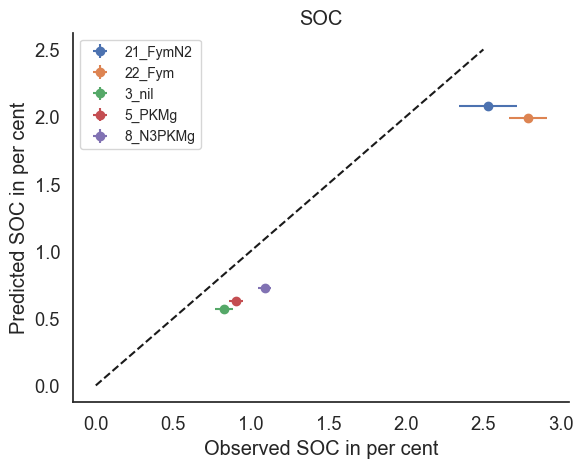

In [67]:
for k, exp in soc_expmts_dict.items():
    x = [np.mean(exp["SOC_obs"]) * 100]
    y = [np.mean(exp["SOC"]) * 100]
    xerr = [np.std(exp["SOC_obs"]) * 100]
    yerr = [np.std(exp["SOC"]) * 100]
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, marker="o", linestyle="none", label=k)
plt.plot([0,2.5], [0,2.5], "k--")
# plt.annotate("$x = y$", (12, 0))
plt.xlabel("Observed SOC in per cent")
plt.ylabel("Predicted SOC in per cent")
plt.title("SOC")
plt.legend(loc="best", fontsize="x-small")
sns.despine()
plt.savefig("soc.svg")
plt.savefig("soc.png")

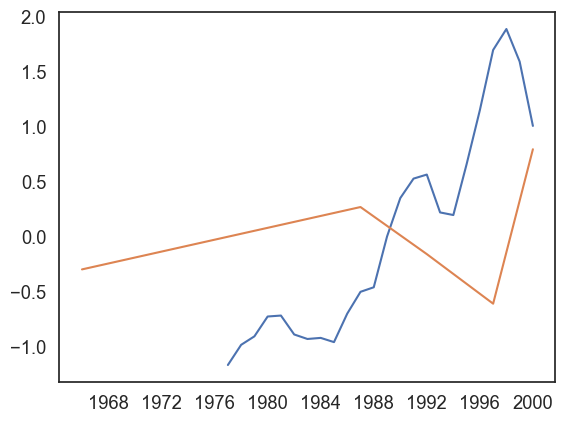

In [106]:
# Means over time
mean_soc = np.mean(np.vstack([exp["SOC"] for exp in soc_expmts]), 1)
mean_soc_obs = np.mean(np.vstack([exp["SOC_obs"] for exp in soc_expmts]), 1)

# Annual means of normalized values across experiments
mean_soc_annual = np.mean(np.vstack([normalize(exp["SOC"]) for exp in soc_expmts]), 0)
mean_soc_obs_annual = np.mean(np.vstack([normalize(exp["SOC_obs"]) for exp in soc_expmts]), 0)

plt.plot(years_dt, mean_soc_annual)
plt.plot(soc["years"], mean_soc_obs_annual)

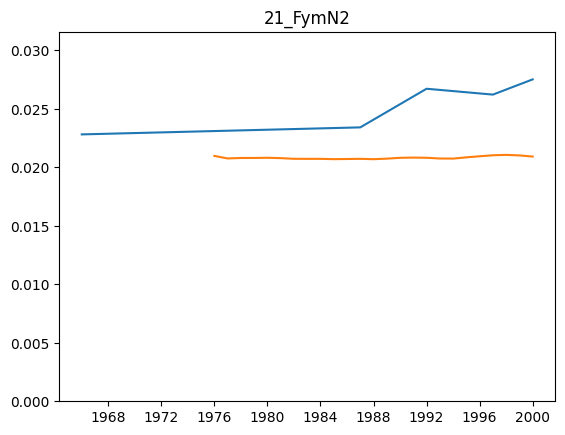

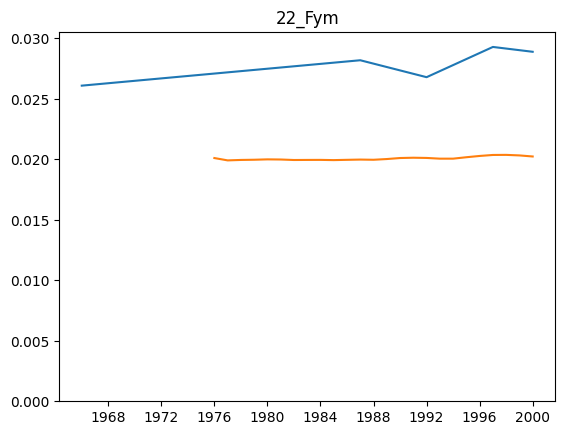

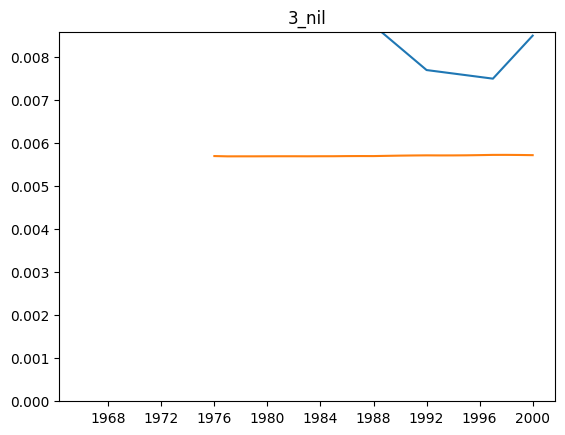

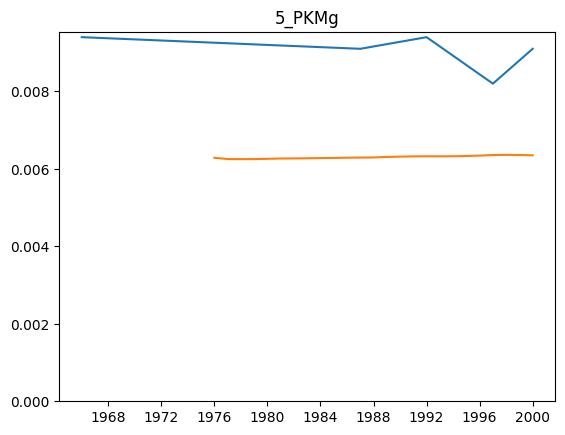

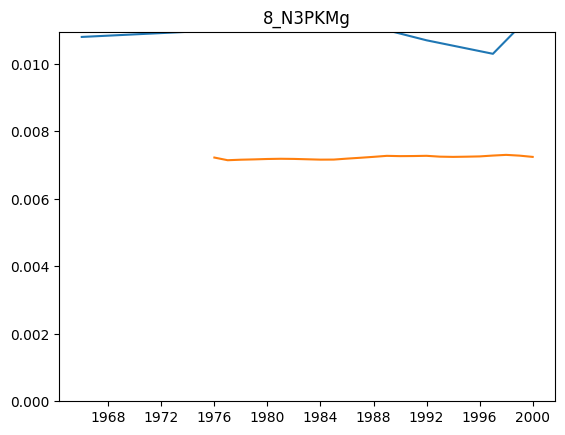

In [265]:
for name, exp in data.items():
    if not "SOC_obs" in exp:
        continue
    plt.figure()
    plt.title(name)
    plt.plot(soc["years"], exp["SOC_obs"])
    plt.plot(exp["years_dt"], exp["SOC"])
    plt.ylim(0, max(exp["SOC"]) * 1.5)

In [ ]:
plt.scatter(

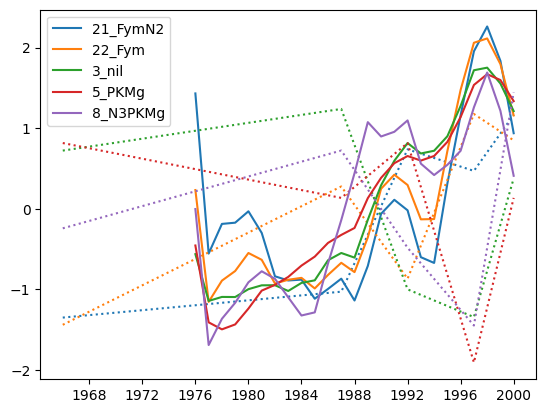

In [237]:
# exp = data["21_FymN2"]
fig, ax = plt.subplots()
for name, exp in data.items():
    if "SOC_obs" in exp:
        color = ax._get_lines.get_next_color()
        plt.plot(exp["years_dt"], normalize(exp["SOC"]), color=color, label=name)
        # plt.plot(exp["days_dt"], normalize(exp["SOC_daily"]))
        plt.plot(soc["years"], normalize(exp["SOC_obs"]), color=color, linestyle="dotted")
plt.legend(loc="best")

In [271]:
# Means over time
mean_soc = np.mean(np.vstack([exp["SOC"] for exp in soc_expmts]), 1)
mean_soc_obs = np.mean(np.vstack([exp["SOC_obs"] for exp in soc_expmts]), 1)

# Annual means of normalized values across experiments
mean_soc_annual = np.mean(np.vstack([normalize(exp["SOC"]) for exp in soc_expmts]), 0)
mean_soc_obs_annual = np.mean(np.vstack([normalize(exp["SOC_obs"]) for exp in soc_expmts]), 0)

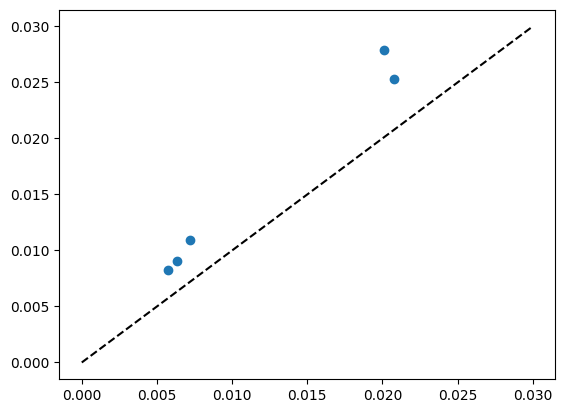

In [272]:
plt.scatter(mean_soc, mean_soc_obs)
plt.plot([0,0.03], [0, 0.03], "k--")

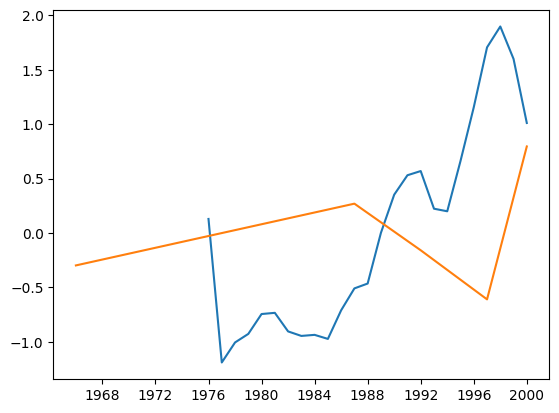

In [250]:
plt.plot(years_dt, mean_soc_annual)
plt.plot(soc["years"], mean_soc_obs_annual)

#### Soil N

In [189]:
soil_n_expmts = [exp for exp in data.values() if "soil_N_obs" in exp]
soil_n_expmts_dict = {k: exp for k, exp in data.items() if "soil_N_obs" in exp}
years_dt = soil_n_expmts[0]["years_dt"]
assert all((exp["years_dt"] == years_dt).all() for exp in soil_n_expmts)


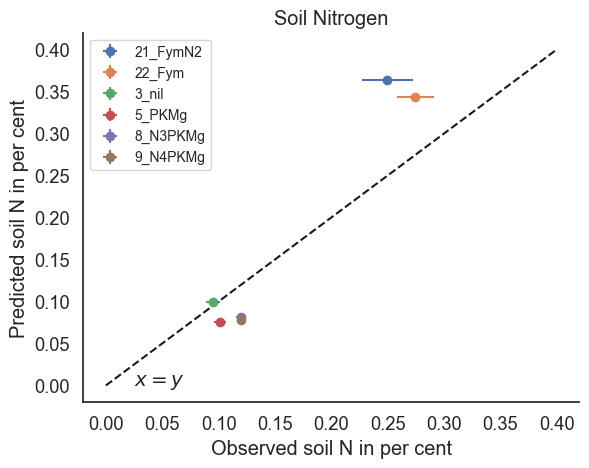

In [69]:
for k, exp in soil_n_expmts_dict.items():
    x = [np.mean(exp["soil_N_obs"]) * 100]
    y = [np.mean(exp["soil_N"]) * 100]
    xerr = [np.std(exp["soil_N_obs"]) * 100]
    yerr = [np.std(exp["soil_N"]) * 100]
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, marker="o", linestyle="none", label=k)
plt.plot([0,0.4], [0,0.4], "k--")
plt.annotate("$x = y$", (0.025, 0))
plt.xlabel("Observed soil N in per cent"
          )
plt.ylabel("Predicted soil N in per cent")
plt.title("Soil Nitrogen")
plt.legend(loc="best", fontsize="x-small")
sns.despine()
plt.savefig("soil_n.svg")
plt.savefig("soil_n.png")

soil_N 9_N4PKMg
SOC 8_N3PKMg
soil_N 8_N3PKMg
SOC 5_PKMg
soil_N 5_PKMg
SOC 3_nil
soil_N 3_nil
SOC 22_Fym
soil_N 22_Fym
SOC 21_FymN2
soil_N 21_FymN2


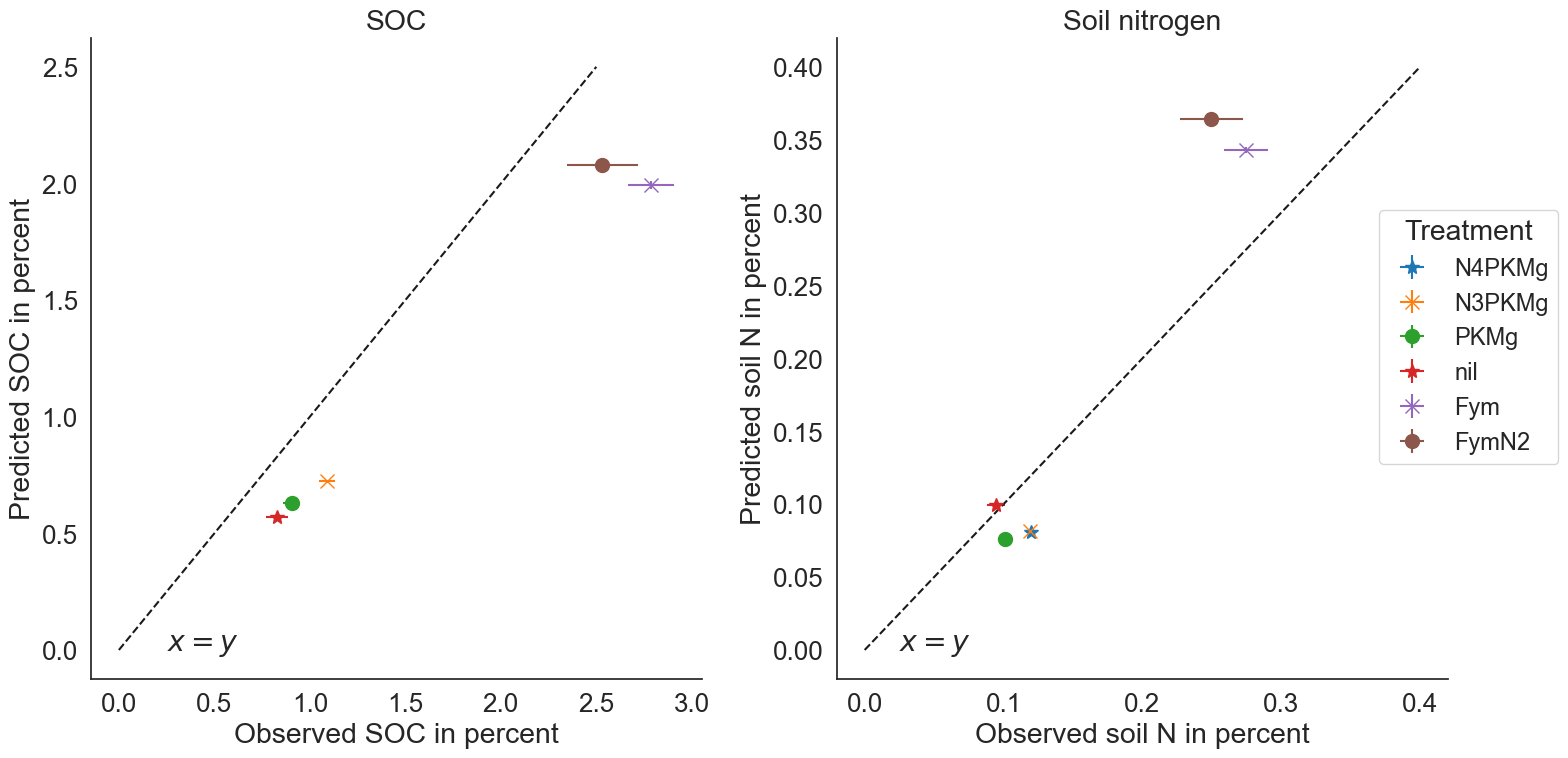

In [190]:
sns.set(font_scale=1.7)
sns.set_style("white")
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
markers = cycle(['*', 'x', 'o'])
# cmap = sns.color_palette('husl', len(data))
cmap = plt.get_cmap('tab10')
color_idx = 0
# for k, exp in reversed(sorted(data.items(), key=lambda x: x[1]["SOC"])):
for k, exp in reversed(sorted(data.items())):
    if "SOC_obs" in exp or "soil_N_obs" in exp:
        label = k[k.find('_') + 1:]
        m = next(markers)
        c = cmap(color_idx)
        color_idx += 1
    if "SOC_obs" in exp:
        print("SOC", k)
        x = [np.mean(exp["SOC_obs"]) * 100]
        y = [np.mean(exp["SOC"]) * 100]
        xerr = [np.std(exp["SOC_obs"]) * 100]
        yerr = [np.std(exp["SOC"]) * 100]
        axs[0].errorbar(x, y, xerr=xerr, yerr=yerr, marker=m, color=c, linestyle="none", label=label, markersize=10)
    if "soil_N_obs" in exp:
        print("soil_N", k)
        x = [np.mean(exp["soil_N_obs"]) * 100]
        y = [np.mean(exp["soil_N"]) * 100]
        xerr = [np.std(exp["soil_N_obs"]) * 100]
        yerr = [np.std(exp["soil_N"]) * 100]
        axs[1].errorbar(x, y, xerr=xerr, yerr=yerr, marker=m, color=c, linestyle="none", label=label, markersize=10)
axs[0].plot([0,2.5], [0,2.5], "k--")
axs[1].plot([0,0.4], [0,0.4], "k--")
axs[0].annotate("$x = y$", (0.25, 0))
axs[1].annotate("$x = y$", (0.025, 0))
axs[0].set_xlabel(r"Observed SOC in percent")
axs[1].set_xlabel(r"Observed soil N in percent")
axs[0].set_ylabel(r"Predicted SOC in percent")
axs[1].set_ylabel(r"Predicted soil N in percent")
axs[0].set_title("SOC")
axs[1].set_title("Soil nitrogen")
axs[1].legend(fontsize="small", bbox_to_anchor=(1.2, 0.75), title="Treatment")
plt.tight_layout()
# plt.legend(loc="best", fontsize="x-small"
sns.despine()
plt.savefig("both_soil.png")

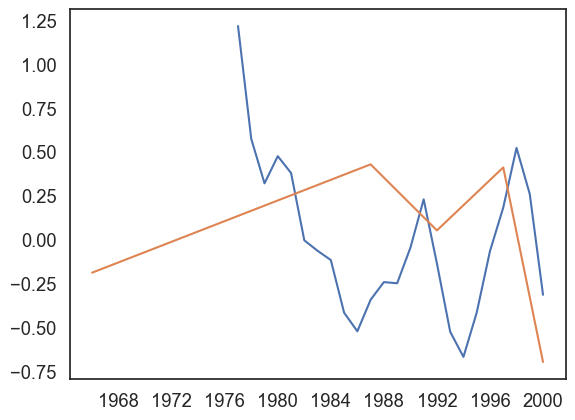

In [105]:
# Means over time
mean_soil_n = np.mean(np.vstack([exp["soil_N"] for exp in soil_n_expmts]), 1)
mean_soil_n_obs = np.mean(np.vstack([exp["soil_N_obs"] for exp in soil_n_expmts]), 1)

# Annual means of normalized values across experiments
mean_soil_n_annual = np.mean(np.vstack([normalize(exp["soil_N"]) for exp in soil_n_expmts]), 0)
mean_soil_n_obs_annual = np.mean(np.vstack([normalize(exp["soil_N_obs"]) for exp in soil_n_expmts]), 0)

plt.plot(years_dt, mean_soil_n_annual)
plt.plot(soil_N["years"], mean_soil_n_obs_annual)

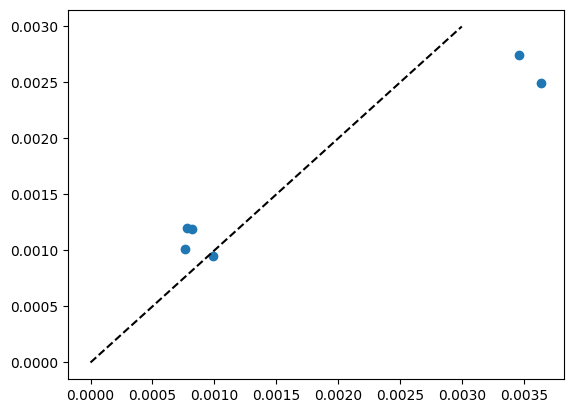

In [284]:
plt.scatter(mean_soil_n, mean_soil_n_obs)
plt.plot([0,0.003], [0, 0.003], "k--")

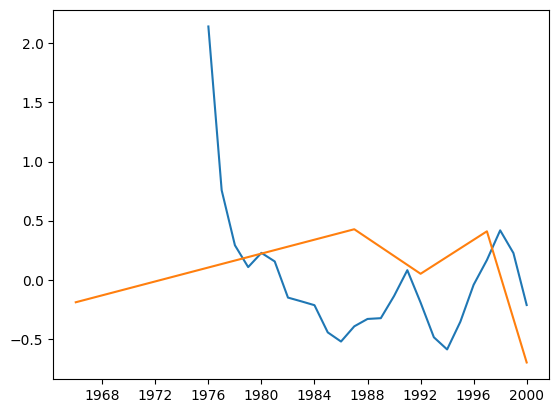

In [257]:
plt.plot(years_dt, mean_soil_n)
plt.plot(soil_n["years"], mean_soil_n_obs)